In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

In [2]:
n_features = 13
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_features).T
    result = mfccs
    return result

In [29]:
wav_file = './discharge-detection/training-data/train_000001.wav'

y, sr = librosa.load(wav_file)
librosa.get_duration(y=y, sr=sr)
y

array([-0.20263077, -0.10089064, -0.05023757, ...,  0.01506726,
        0.02403296,  0.        ], dtype=float32)

In [21]:
def get_file_duration(file_name):
    y, sr = librosa.load(file_name)
    return librosa.get_duration(y=y, sr=sr)

In [22]:
training_folder = './discharge-detection/training-data/'

files = list(glob.glob('{}/*.wav'.format(training_folder)))
file_durations = []
for fn in files:
    file_durations.append(get_file_duration(fn))
print(len(file_durations))

8523


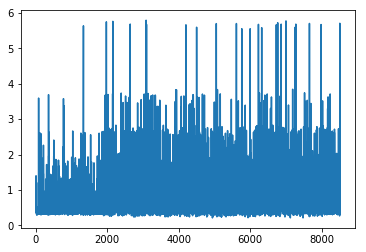

In [23]:
plt.plot(file_durations)

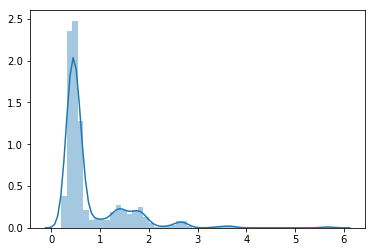

In [28]:
import seaborn as sns
sns.distplot(file_durations)

In [13]:
import sklearn
import scipy

In [25]:
print(np.amin(file_durations))
print(np.amax(file_durations))

0.20970521542
5.79337868481


In [16]:
test_folder = './discharge-detection/test-data/'

test_files = list(glob.glob('{}/*.wav'.format(test_folder)))
test_file_durations = []
for fn in test_files:
    test_file_durations.append(get_file_duration(fn))
print(len(test_file_durations))

5137


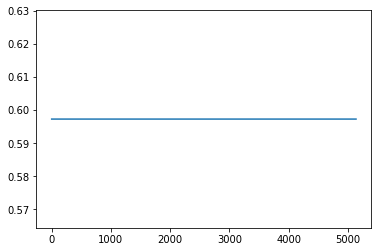

In [17]:
plt.plot(test_file_durations)

In [18]:
def parse_audio_file(filename, label):
    features = extract_feature(filename)
    labels = np.full((np.size(features, 0)), label)
    return features, labels

In [55]:
extract_feature('./discharge-detection/training-data/train_004790.wav').shape

(11, 13)

In [56]:
feature = extract_feature('./discharge-detection/training-data/train_004790.wav')
min_height = 10
height = feature.shape[0]
for i in range(0, height - min_height+1):
    print(feature[i:i+min_height, :].shape)

(10, 13)
(10, 13)


In [58]:
import csv
def get_labels(file_name):
    labels = {}
    with open(file_name, 'r') as label_file:
        label_reader = csv.reader(label_file)
        next(label_reader, None)
        for row in label_reader:
            file_name, label = row
            labels[file_name] = int(label)
    return labels
    
train_labels = get_labels('./discharge-detection/training-data/train_labels.csv')

In [59]:
train_labels

{'train_000001.wav': 1,
 'train_000002.wav': 1,
 'train_000003.wav': 1,
 'train_000004.wav': 1,
 'train_000005.wav': 1,
 'train_000006.wav': 1,
 'train_000007.wav': 1,
 'train_000008.wav': 1,
 'train_000009.wav': 1,
 'train_000010.wav': 1,
 'train_000011.wav': 1,
 'train_000012.wav': 1,
 'train_000013.wav': 1,
 'train_000014.wav': 1,
 'train_000015.wav': 1,
 'train_000016.wav': 1,
 'train_000017.wav': 1,
 'train_000018.wav': 1,
 'train_000019.wav': 1,
 'train_000020.wav': 1,
 'train_000021.wav': 1,
 'train_000022.wav': 1,
 'train_000023.wav': 1,
 'train_000024.wav': 1,
 'train_000025.wav': 1,
 'train_000026.wav': 1,
 'train_000027.wav': 1,
 'train_000028.wav': 1,
 'train_000029.wav': 1,
 'train_000030.wav': 1,
 'train_000031.wav': 1,
 'train_000032.wav': 1,
 'train_000033.wav': 1,
 'train_000034.wav': 1,
 'train_000035.wav': 1,
 'train_000036.wav': 1,
 'train_000037.wav': 1,
 'train_000038.wav': 1,
 'train_000039.wav': 1,
 'train_000040.wav': 1,
 'train_000041.wav': 1,
 'train_000042.w

In [60]:
parent_dir = './discharge-detection'
tr_sub_dirs = ["training-data"]
ts_sub_dirs = ["test-data"]

In [ ]:
all_features = []
all_labels = []
def parse_audio_files(parent_dir,sub_dirs, file_ext="*.wav"):
    for _, sub_dir in enumerate(sub_dirs):
        print("processing in subdir {}".format(sub_dir))
        file_count = 0
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            file_count += 1
            if file_count % 1000 ==0:
                print("file counts {}...".format(file_count))
            (_, filename) = os.path.split(fn)
            label = train_labels.get(filename, 0)
            features = extract_feature(fn)
            height = features.shape[0]
            for i in range(0, height - min_height + 1):
                ext_features = features[i:i+min_height, :]
                all_features.append(ext_features)
#                 all_labels.append(np.full((np.size(ext_features, 0)), label))
                all_labels.append(label)
parse_audio_files(parent_dir, tr_sub_dirs)
print("done processing files")

processing in subdir training-data
file counts 1000...
file counts 2000...
file counts 3000...
file counts 4000...
file counts 5000...
file counts 6000...
file counts 7000...


In [130]:
all_features = np.asarray(all_features)
all_labels = np.asarray(all_labels)
all_labels = all_labels.reshape(-1, 1)
print(np.asarray(all_features).shape)
print(np.asarray(all_labels).shape)

(57153, 10, 13)
(57153,)


In [134]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels)
X_train = np.expand_dims(X_train, axis=3)

In [136]:
X_train.shape

(42864, 10, 13, 1)

In [147]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, ZeroPadding2D, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import backend as K
K.set_image_dim_ordering('tf')

inputs = Input(shape=all_features.shape, dtype='float32')
act = 'relu'
pool_size = 2
n_batch_size = 50
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same', activation=act, kernel_initializer='he_normal', input_shape=(10, 13, 1)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Conv2D(64, (5, 5), padding='same', activation=act, kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(1000, activation=act))
# model.add(Dense(100, activation=act))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=n_batch_size, epochs=10)

Epoch 1/10
42864/42864 [==============================] - 25s 578us/step - loss: 8.8999 - acc: 0.4417
Epoch 2/10
42864/42864 [==============================] - 24s 557us/step - loss: 8.8999 - acc: 0.4417
Epoch 3/10
13050/42864 [========>.....................] - ETA: 17s - loss: 8.8178 - acc: 0.4469

KeyboardInterrupt: 